In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import cv2 as cv
import os 
import sklearn.model_selection as pp
from torch.utils.data import TensorDataset, DataLoader


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [2]:
test_path = "/Users/bhara-zstch1566/CNN/Project/Hand_deteaction /Dataset/asl_alphabet_train/asl_alphabet_train"

In [3]:

X = []
for folder in os.listdir(test_path):
    if folder==".DS_Store":
        continue
    for img_name in os.listdir(os.path.join(test_path, folder)):
        if folder==".DS_Store":
            continue
        img_path = os.path.join(test_path, folder, img_name)
        img = cv.imread(img_path)
        
        X.append(img)

In [4]:
len(X)

87000

In [5]:
Y = []

for folder in os.listdir(test_path):
    if folder==".DS_Store":
        continue
    for img_name in os.listdir(os.path.join(test_path, folder)):
        img_path = os.path.join(test_path, folder, img_name)
        let = (img_name)
        if "nothing" in let or "space" in let or "del" in let:
            Y.append(let.upper().split('.')[0][:3])
            continue
        Y.append(let.upper().split('.')[0][0])
        
            
print(len(sorted(list(set(Y)))))

29


In [6]:
print(len(Y))

87000


In [7]:
lis = ['A', 'B', 'C', 'D', 'DEL', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOT', 'O', 'P', 'Q', 'R', 'S', 'SPA', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

dic ={}
for i in range(len(lis)):
    dic [lis[i]] = i

dic 

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'DEL': 4,
 'E': 5,
 'F': 6,
 'G': 7,
 'H': 8,
 'I': 9,
 'J': 10,
 'K': 11,
 'L': 12,
 'M': 13,
 'N': 14,
 'NOT': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'SPA': 21,
 'T': 22,
 'U': 23,
 'V': 24,
 'W': 25,
 'X': 26,
 'Y': 27,
 'Z': 28}

In [8]:
for i in range(len(Y)):
    Y[i] = dic[Y[i]]


In [9]:
len(X)

87000

In [10]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def ta(x):
    for i in range(len(x)):
        x[i] = transform(x[i])
    return x
X = ta(X)

In [11]:
len(X)

87000

In [12]:
Y = t.Tensor(Y)

In [13]:
Y.shape
Y.shape

torch.Size([87000])

In [14]:
X = t.stack(X)


In [15]:
X.shape

torch.Size([87000, 3, 64, 64])

In [16]:
x_train,x_test,y_train,y_test = pp.train_test_split(X,Y,test_size=0.2,random_state=42)

In [17]:
train_dataset = TensorDataset(x_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(x_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
X.shape

torch.Size([87000, 3, 64, 64])

In [19]:
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet,self).__init__()
        self.Convlayer = nn.Sequential(
            nn.Conv2d(3,64,11,stride=2,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),       
            nn.Conv2d(64,128,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,stride=1,padding=1),
            nn.ReLU()
        )

        self.net = nn.Sequential(
            nn.Linear(256*7*7,4096),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(4096,29)
        )
    def forward(self,x):
        x = self.Convlayer(x)
        x = x.view(x.size(0), -1)
        x = self.net(x)
        return x


In [20]:
from torchvision import models
from torchsummary import summary

In [21]:
model = Alexnet()
createrion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [22]:
epochs = 10
device = "mps" if t.mps.is_available() else "cpu"
model = model.to(device)
all_preds=[]
all_labels = []

In [23]:
X.shape

torch.Size([87000, 3, 64, 64])

In [24]:
for epoch in range(epochs):
    running = 0.0
    for img,label in train_loader:
        img , label = img.to(device),label.to(device)
        y_pred = model(img)
        loss = createrion(y_pred,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running +=loss.item()
        
    with t.no_grad():
        ttotal =0
        tcet = 0
        for img,label in test_loader:
            img ,label = img.to(device),label.to(device)
            y_pred = model(img)
            _,predicted = t.max(y_pred.data, 1)
            ttotal += label.size(0)
            tcet += (predicted == label).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    print(f"Epoch [{epoch+1}/{5}], Loss: {running / len(train_loader):.4f}, Accuracy: {100*tcet/ttotal:.2f}%")


Epoch [1/5], Loss: 1.4177, Accuracy: 81.24%
Epoch [2/5], Loss: 0.4570, Accuracy: 88.81%
Epoch [3/5], Loss: 0.3334, Accuracy: 92.07%
Epoch [4/5], Loss: 0.3204, Accuracy: 92.04%
Epoch [5/5], Loss: 0.2921, Accuracy: 92.20%
Epoch [6/5], Loss: 0.2978, Accuracy: 92.20%
Epoch [7/5], Loss: 0.2761, Accuracy: 93.04%
Epoch [8/5], Loss: 0.2880, Accuracy: 94.21%
Epoch [9/5], Loss: 0.2793, Accuracy: 93.23%
Epoch [10/5], Loss: 0.2672, Accuracy: 93.79%


In [25]:
tot = 0
crt = 0
path = "/Users/bhara-zstch1566/CNN/Project/Hand_deteaction /Dataset/asl_alphabet_test/asl_alphabet_test"
for filename in os.listdir(path):
    if filename==".DS_Store":
        continue
    img = cv.imread(path+'/'+filename)
    img = transform((img))
    img =img.unsqueeze(0)
    img = img.to(device)
    with t.no_grad():
        y_pred = model(img)
        _,predicted = t.max(y_pred.data, 1)
        tot+=1
        crt+=filename.split('_')[0].upper()[:3]==lis[predicted]
        print(filename.split('_')[0].upper(),lis[predicted])
print(f"percentage : {crt/tot*100}")

F F
G G
L L
M M
R R
S S
X X
Y Y
U U
T T
A A
K K
J J
Z Z
NOTHING NOT
Q Q
P P
SPACE SPA
O O
N N
E E
D D
H H
I I
B B
C C
V V
W W
percentage : 100.0


In [ ]:
t.save(model.state_dict(), "model1.pth")

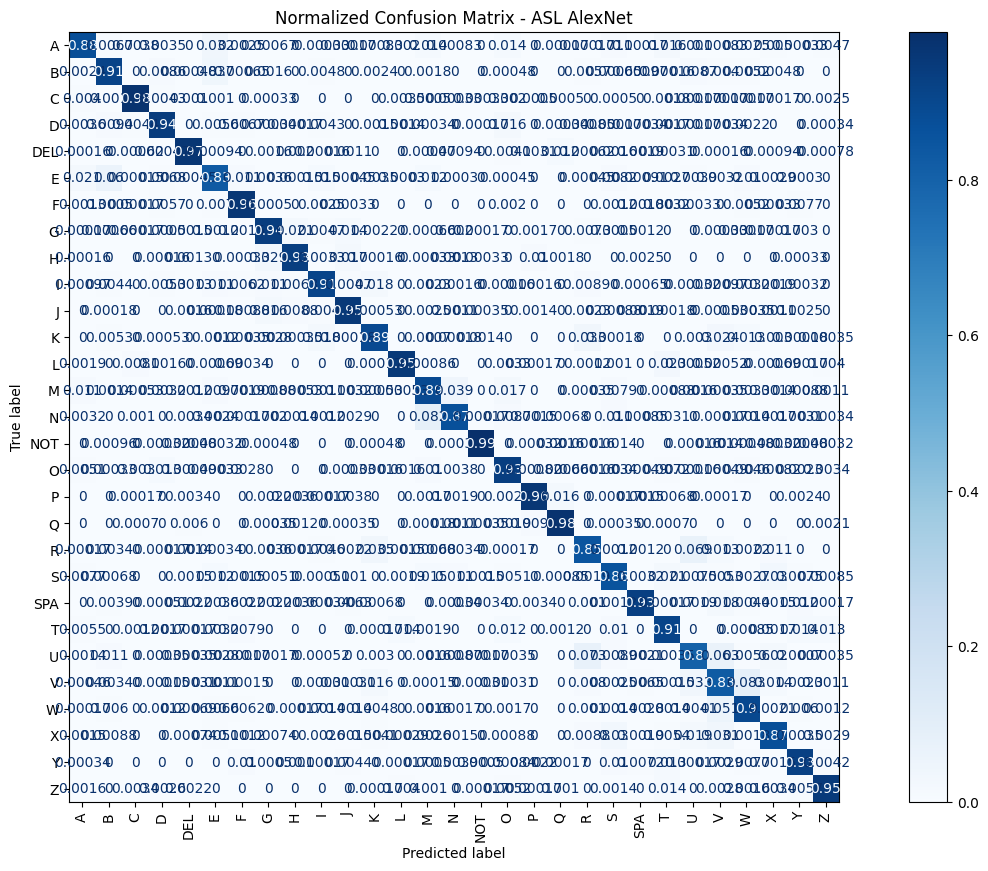

In [27]:
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# --- Display ---
fig, ax = plt.subplots(figsize=(18, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=lis)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Normalized Confusion Matrix - ASL AlexNet")
plt.show()
